In [170]:
from datetime import datetime
import local_helpers as lh
import vaex
import h3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely import wkt
import category_encoders as ce


# Feature Engineering

### Previous demand as input

As we have given time series data, it is a common approach to use the demand of previous hours (or days etc.) as an input for the prediction. The assumption we hereby make is that the factors that influence the demand have not changed dramatically within the used time frames. We have decided to construct the following features from previous demand:

* 2 hour: The asssumption is that the demand should not change dramatically between three hours.
* 24 hours: The asssumption is that the current demand should be comparable to the demand exactly one day ago, as factors such as season, time of the day are the same.
* Average demand of the past week at the same day time: This feature is the average of all 7 demand observations of the past week at same time of the day. 

In [171]:
# This functions loads the dataset either with hexagons or census tract
def load_dataset_to_pandas(resolution=10, location_type_hexagon = True):
    df = vaex.open('./data/trips_prepared.hdf5')
    df.head()

    df["trip_start_day"] = df.trip_start_timestamp.dt.day
    df["trip_start_month"] = df.trip_start_timestamp.dt.month
    df["trip_start_hour"] = df.trip_start_timestamp.dt.hour
    df["trip_start_minute"] = df.trip_start_timestamp.dt.minute

    if location_type_hexagon:
        
        
    
        RESOLUTION = resolution
        def geo_to_h3(row1, row2):
            return h3.geo_to_h3(row1,row2, RESOLUTION)

        # Step 1: For each pickup and drop-off calculate the correct hexagon in the resolution
        df['pickup_loc'] = df.apply(geo_to_h3, [df['pickup_centroid_latitude'], df['pickup_centroid_longitude']])
    else:
        df.rename('pickup_census_tract', 'pickup_loc')

    ### Group by hour
    df_demand = df.groupby(['trip_start_hour', 'trip_start_month', 'trip_start_day', 'pickup_loc']).agg({'demand': 'count'})
    # Add timestamp as preparation for resampling
    df_demand['timestamp'] = pd.to_datetime({'year': 2017, 'month': df_demand['trip_start_month'].to_numpy(), 'day': df_demand['trip_start_day'].to_numpy(), 'hour': df_demand['trip_start_hour'].to_numpy()}).to_numpy()

    # convert to pandas df
    df_demand = df_demand.to_pandas_df()
    return df_demand


In [172]:
def resample_to_hourly(df):
    ### Creation of dummy df which contains hourly data dummy data over an entire year per hexagon
    # Create a DateTimeIndex with hourly intervals for the year 2017
    start_date = '2017-01-01 00:00:00'
    end_date = '2017-12-31 23:00:00'
    hourly_range = pd.date_range(start=start_date, end=end_date, freq='H')
    num_entries_per_year = len(hourly_range)
    hour_range = np.tile(hourly_range.hour,len(np.unique(df.pickup_loc)))
    month_range = np.tile(hourly_range.month,len(np.unique(df.pickup_loc)))
    day_range = np.tile(hourly_range.day,len(np.unique(df.pickup_loc)))
    hourly_range = np.tile(hourly_range,len(np.unique(df.pickup_loc)))

    # -1 values will indacte that these rows were artificially generated later on
    data = {
        'trip_start_hour': hour_range,
        'trip_start_month': month_range,
        'trip_start_day': day_range,
        'pickup_loc': np.repeat(np.unique(df.pickup_loc), num_entries_per_year),
        'demand': 0,
    }

    df_hourly = pd.DataFrame(data, index=hourly_range)
    df_hourly= df_hourly.set_index([df_hourly.index, 'pickup_loc'])

    # introduce multiindex for filling up the df with hourly index later on
    df=df.set_index(['timestamp', 'pickup_loc'])

    # insert df 
    df_hourly.update(df)

    # clear up multi-index
    df_hourly=df_hourly.reset_index()
    df_hourly.columns = ['timestamp','pickup_loc','trip_start_hour','trip_start_month','trip_start_day','demand']
    return df_hourly
    

In [173]:
def get_target_time_bucket_demand(df):
    
    demand_cols = [f'demand_n-{num}' for num in list(range(0,25))]
    
    for shift in list(range(0,25)):
        df[f'demand_n-{shift}'] =  df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift((-1)*shift)
        
    two_hours = ['demand_n-0','demand_n-1']
    six_hours = [f'demand_n-{num}' for num in list(range(0,6))]
    twentyfour_hours = [f'demand_n-{num}' for num in list(range(0,24))]
    
    df['demand_target_bucket_1'] = df['demand_n-0']
    df['demand_target_bucket_2'] = df[two_hours].sum(axis=1)
    df['demand_target_bucket_6'] = df[six_hours].sum(axis=1)
    df['demand_target_bucket_24'] = df[twentyfour_hours].sum(axis=1)
    df = df.drop(labels=demand_cols, axis=1)
    
    
    
    return df

In [174]:
def get_past_time_bucket_demand(df):
    
    demand_cols = [f'demand_p-{num}' for num in list(range(0,24))]
    
    for shift in list(range(0,25)):
        df[f'demand_p-{shift}'] =  df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift(shift)
        
    two_hours = ['demand_p-0', 'demand_p-1']
    six_hours = [f'demand_p-{num}' for num in list(range((24-5),25))]
    twentyfour_hours = [f'demand_p-{num}' for num in list(range(1,25))]
    
    df['demand_bucket_2'] = df[two_hours].sum(axis=1)
    df['demand_bucket_6'] = df[six_hours].sum(axis=1)
    df['demand_bucket_24'] = df[twentyfour_hours].sum(axis=1)
    df = df.drop(labels=demand_cols, axis=1)
    
    
    
    return df

In [175]:
def get_past_single_hour_demand(df):
    # insert features 1, 2 and 24 hours previous demand
    df['demand_h-1'] = df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift(1)
    df['demand_h-2'] = df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift(2)
    df['demand_h-24'] = df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift(24)
    return df

# Weather features
In the descriptive analysis, particularly the analysis of temporal demand patterns, we found that the temperature and demand curves follow similar directions. Therefore, we construct features based on temperature to enable models that capture this relationship.

### Include weather data
First, we have to include the weather data into the dataframe. For this we just need to merge the two datasets, as both are already in hourly frequency. The weather data propose data for minute 53 of an hour. Therefore, we round up to the nearest hour for each row. We suppose that the weather changes in seven minutes can be disregarded.

In [176]:
def weather_categories(weather):
    if "Fair" in weather:
        return "Clear/Sunny"
    elif "Cloudy" in weather:
        return "Cloudy"
    elif "Rain" in weather or "Drizzle" in weather or "T-Storm" in weather or "Thunder" in weather:
        return "Rain/Storms"
    elif "Snow" in weather or "Wintry" in weather:
        return "Snow/Winter Conditions"
    elif weather in ["Fog", "Haze", "Smoke", "Widespread Dust / Windy"]:
        return "Other"
    else:
        return "Miscellaneous"
    
def merge_weather(df):
    # read and merge weather data
    df_weather = pd.read_csv('data/weather_data_final.csv')
    df_weather['date_time'] = pd.to_datetime(df_weather['date_time'])
    df_weather['date_time'] = df_weather['date_time'].dt.ceil('H')
    df_weather.rename(columns={'date_time': 'timestamp'}, inplace=True)

    # cast data types
    df_weather['temp'] = df_weather['temp'].str.replace('\xa0°F', '').astype(float).fillna(np.nan)
    df_weather['dew_point'] = df_weather['dew_point'].str.replace('\xa0°F', '').astype(float).fillna(np.nan)
    df_weather['humidity'] = df_weather['humidity'].str.replace('\xa0°%', '').astype(float).fillna(np.nan)
    df_weather['wind_speed'] = df_weather['wind_speed'].str.replace('\xa0°mph', '').astype(float).fillna(np.nan)
    df_weather['wind_gust'] = df_weather['wind_gust'].str.replace('\xa0°mph', '').astype(float).fillna(np.nan)
    df_weather['pressure'] = df_weather['pressure'].str.replace('\xa0°in', '').astype(float).fillna(np.nan)
    df_weather['precip'] = df_weather['precip'].str.replace('\xa0°in', '').astype(float).fillna(np.nan)
    df_weather = df_weather.drop(['time','date', 'dew_point'], axis=1)
    df_weather['condition'] = df_weather["condition"].apply(weather_categories)
    df_weather = pd.get_dummies(df_weather, columns=['condition'])


    df = df.merge(df_weather, on='timestamp', how='left')
    return df

### Temperature features
In addition to the current temperature, we are add the temperature from 1, 2, and 3 hours prior to the time of taxi demand. We suggest that past temperature conditions could potentially impact the decision to hire a taxi.

In [177]:
def get_past_temperature(df):
    df['temp_h-1'] = df.sort_values('timestamp').groupby('pickup_loc')['temp'].shift(1)
    df['temp_h-2'] = df.sort_values('timestamp').groupby('pickup_loc')['temp'].shift(2)
    df['temp_h-3'] = df.sort_values('timestamp').groupby('pickup_loc')['temp'].shift(3)
    return df

### Precipitation
We hypothesize that precipitation has a significant impact on demand. Therefore, we construct features that describe whether it has rained in the last 1-3 hours.

In [178]:
def get_past_precip(df):
    df['precip_h-1'] = df.sort_values('timestamp').groupby('pickup_loc')['precip'].shift(1)
    df['precip_h-2'] = df.sort_values('timestamp').groupby('pickup_loc')['precip'].shift(2)
    df['precip_h-3'] = df.sort_values('timestamp').groupby('pickup_loc')['precip'].shift(3)
    return df

### Season
We suggest that demand changes over seasons.

In [179]:
def date_to_season(date):
    if pd.Timestamp(2017, 12, 22) <= date or date < pd.Timestamp(2017, 3, 20):
        return 'winter'
    elif pd.Timestamp(2017, 3, 20) <= date < pd.Timestamp(2017, 6, 21):
        return 'spring'
    elif pd.Timestamp(2017, 6, 21) <= date < pd.Timestamp(2017, 9, 23):
        return 'summer'
    else:
        return 'autumn'

def get_season(df):
    # Vectorize the date_to_season function
    date_to_season_vec = np.vectorize(date_to_season)
    
    # Apply the vectorized function to the 'timestamp' column
    df['season'] = date_to_season_vec(df['timestamp'])
    
    # Create dummies
    df = pd.get_dummies(df, columns=['season'])
    
    return df

### Weekend feature
In the descriptive analysis we have seen that demand changes depending on weekend or not. Hence we engineer a feature "weekend" which is 1 for all rides on saturday & sunday and zero for all other days.

In [180]:
def get_weekend(df):
    df['weekend'] = (df['timestamp'].dt.weekday >= 5).astype(int)
    return df

### Daytime features
In addition, descriptive analysis has shown that the time of day, i.e., whether it is night, morning, afternoon, or evening, plays an important role in determining demand. Therefore, we developed four characteristics, each indicating whether a trip occurs during the following times.
* Morning: 6 a.m. - 12 p.m.
* Afternoon: 12 noon - 6 p.m.
* Evening: 6 p.m. - 11 p.m.
* Night: 12 a.m. - 6 a.m.

In [181]:
def get_pnt_day_with_pnt_week(dt):
    dt = pd.to_datetime(dt)  
    time_of_week = "week" if dt.weekday() < 5 else "weekend"
    hour = dt.hour

    if 6 <= hour < 12:
        return "morning_" + time_of_week
    elif 12 <= hour < 18:
        return "afternoon_" + time_of_week
    elif 18 <= hour < 23:
        return "evening_" + time_of_week
    else:
        return "night_" + time_of_week

def get_daytime(df):
    vfunc = np.vectorize(get_pnt_day_with_pnt_week)
    df['daytime'] = vfunc(df['timestamp'])
    dummies = pd.get_dummies(df['daytime']).astype(int)
    df = pd.concat([df.drop(['daytime'], axis=1), dummies], axis=1)
    return df


### Event Features
Events such as public holidays might influence the demand. In order to capture these patterns we introduce the public holiday feature

There were several public holidays in Boston:
* Martin Luther King Day: Monday, January 16, 2017
* Lincoln's Birthday: Monday, February 13, 2017
* Washington's Birthday (President's Day): Monday, February 20, 2017
* Memorial Day: Monday, May 29, 2017
* Independence Day: Tuesday, July 04, 2017
* Labor Day: Monday, September 04, 2017
* Columbus Day: Monday, October 09, 2017
* Veterans' Day: Friday, November 10, 2017
* Thanksgiving Day: Thursday, November 23, 2017
* Thanksgiving Day: Friday, November 24, 2017
* Christmas Day: Monday, December 25, 2017

These events might have influenced the demand

In [182]:
holiday_dates = [
    datetime(2017, 1, 2),   # New Year's Day
    datetime(2017, 1, 16),  # Martin Luther King Day
    datetime(2017, 2, 13),  # Lincoln's Birthday
    datetime(2017, 2, 20),  # Washington's Birthday (President's Day)
    datetime(2017, 5, 29),  # Memorial Day
    datetime(2017, 7, 4),   # Independence Day
    datetime(2017, 9, 4),   # Labor Day
    datetime(2017, 10, 9),  # Columbus Day
    datetime(2017, 11, 10), # Veterans' Day
    datetime(2017, 11, 23), # Thanksgiving Day
    datetime(2017, 11, 24), # Day after Thanksgiving
    datetime(2017, 12, 25), # Christmas Day
]

def get_holiday_dates(df):
    df['is_holiday'] = df['timestamp'].isin(holiday_dates).astype(int)
    return df

### Neighbor demand feature
We expect a high correlation between the demand of one hexagon and the demand in the surrounding hexagons. With this feature we can observe demand patterns in a greater radius than only in the observed location.

In [231]:
df = load_dataset_to_pandas(location_type_hexagon=False) 
df = resample_to_hourly(df)
df = get_past_single_hour_demand(df)

In [232]:
df = get_past_time_bucket_demand(df)

In [247]:
df.drop(columns=["trip_start_hour","trip_start_month","trip_start_day"])
df['pickup_loc'] = df['pickup_loc'].astype(int)

In [288]:
# Function to load data from CSV and preprocess it
def preprocess_census_data():
    df_census_tracts = pd.read_csv("data/chicago_census_tracts.csv")
    df_census_tracts['geometry'] = df_census_tracts['the_geom'].apply(wkt.loads)
    df_census_tracts = df_census_tracts.rename(columns={'geometry': 'geometry'})

    gdf = gpd.GeoDataFrame(df_census_tracts, geometry='geometry')
    gdf = gdf.set_crs(epsg=4326, allow_override=True)
    gdf = gdf.to_crs(epsg=3857)
    return gdf

# Function to get neighbors using H3
def get_h3_neighbors(df):
    pickup_locs = df["pickup_loc"].unique()
    return {loc: h3.k_ring(loc, k=1) for loc in pickup_locs}

# Function to get neighbors from Census data
def get_census_neighbors(gdf, buffer_distance=100):
    gdf_buffered = gdf.copy()
    gdf_buffered['geometry'] = gdf.buffer(buffer_distance)
    gdf['geometry'] = gdf_buffered.geometry  # Replace original geometry with buffered one
    census_tract_neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')
    census_tract_neighbors = census_tract_neighbors[census_tract_neighbors.index != census_tract_neighbors.index_right]
    return census_tract_neighbors.groupby('GEOID10_left')['GEOID10_right'].apply(list).to_dict()

In [289]:
# get dataframe with mean demand value of each hexagon/census tract
def get_neighbor_demand(df):
    locs = df["pickup_loc"].unique
    if h3.h3_is_valid(df["pickup_loc"].iloc[0]):
        neighbors_dict = get_h3_neighbors(df)
    else:
        gdf = preprocess_census_data()
        neighbors_dict = get_census_neighbors(gdf)

    df['neighbors'] = df['pickup_loc'].map(neighbors_dict)
    df = df.drop(columns=["trip_start_hour", "trip_start_month", "trip_start_day"])
    return df

In [290]:
gdf = preprocess_census_data()
neighbors_dict = get_census_neighbors(gdf)

In [301]:
neighbors = neighbors_dict.values()
flat_list = [item for sublist in neighbors for item in sublist]
len(set(flat_list))


801

In [304]:
pickup_locs = df["pickup_loc"].unique()
len(set(pickup_locs))

357

In [291]:
df_copy = df.copy()
df_copy['neighbor_mean'] = 0
df_pickups = []
for key in df_copy['pickup_loc'].unique():
     df_loc = df_copy[df_copy['pickup_loc']== key].copy()
     df_loc = df_loc.sort_values('timestamp').reset_index(drop=True)
     for neighbor in neighbors_dict[int(key)]:
         df_loc[str(neighbor)] = 0
         df_loc[str(neighbor)] = df_copy[df_copy['pickup_loc'] == neighbor].sort_values('timestamp')['demand_h-1'].reset_index(drop=True)
        
     neighbors = list(map(str, neighbors_dict[key]))    
     df_loc['neighbor_mean'] = df_loc[neighbors].mean(axis=1, skipna=True)
     df_loc.drop(neighbors, axis = 1, inplace=True)
     df_pickups.append(df_loc)

df_w_neighbors = pd.concat(df_pickups)

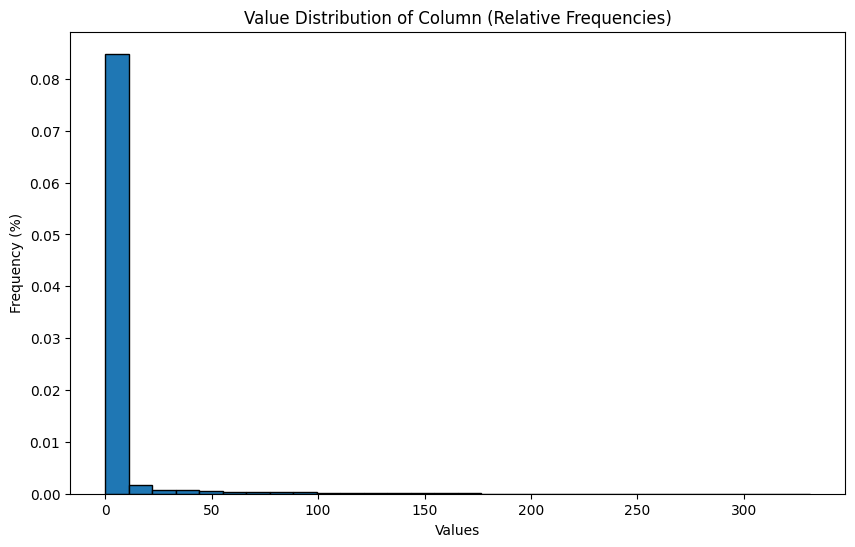

In [292]:
# Create a histogram to visualize the value distribution of the column
# Create a histogram to visualize the value distribution of the column with relative frequencies
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size for better visibility
plt.hist(df_w_neighbors['neighbor_mean'], bins=30, range=(0, 331), edgecolor='black', density=True)  # Set density=True

# Set plot title and labels
plt.title('Value Distribution of Column (Relative Frequencies)')
plt.xlabel('Values')
plt.ylabel('Frequency (%)')  # Label with percentage sign

# Display the histogram
plt.show()

In [ ]:
i=0
def get_mean_demand_h_1(row, df):
    global i
    i+=1
    if i%10000==0:
        print(i)
    neighbor_locs = row['neighbors']
    mean_demand_h_1 = df[df['pickup_loc'].isin(neighbor_locs)]['demand_h-1'].mean()
    return mean_demand_h_1

# apply the function to each row
df['mean_neighbor_demand_h-1'] = df.apply(get_mean_demand_h_1, df=df, axis=1)


In [ ]:
# # Function to load data from CSV and preprocess it
# def preprocess_census_data():
#     df_census_tracts = pd.read_csv("data/chicago_census_tracts.csv")
#     df_census_tracts['geometry'] = df_census_tracts['geometry'].apply(wkt.loads)
#     df_census_tracts = df_census_tracts.rename(columns={'geometry': 'geometry'})

#     gdf = gpd.GeoDataFrame(df_census_tracts, geometry='geometry')
#     gdf = gdf.set_crs(epsg=4326, allow_override=True)
#     gdf = gdf.to_crs(epsg=3857)
#     return gdf

# # Function to get neighbors using H3
# def get_h3_neighbors(df):
#     pickup_locs = df["pickup_loc"].unique()
#     return {loc: h3.k_ring(loc, k=1) for loc in pickup_locs}

# # Function to get neighbors from Census data
# def get_census_neighbors(gdf, buffer_distance=500):
#     gdf_buffered = gdf.copy()
#     gdf_buffered['geometry'] = gdf.buffer(buffer_distance)
#     gdf['geometry'] = gdf_buffered.geometry  # Replace original geometry with buffered one
#     census_tract_neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')
#     census_tract_neighbors = census_tract_neighbors[census_tract_neighbors.index != census_tract_neighbors.index_right]
#     return census_tract_neighbors.groupby('GEOID10_left')['GEOID10_right'].apply(list).to_dict()

# # Function to get neighbor demand by ID
# def get_neighbor_demand_by_ID(df_timestamp, pickup_loc, neighbors_dict):
#     neighbors = neighbors_dict[pickup_loc]
#     neighbor_demand = df_timestamp[df_timestamp['pickup_loc'].isin(neighbors)]['demand_h-1'].mean()
#     return neighbor_demand

# i = 0
# def get_group_demand(df_group, neighbors_dict):
#     i+=1
#     if i%10000==0:
#         print(i)
#     df_group['neighbor_demand_h-1'] = df_group.apply(lambda row: get_neighbor_demand_by_ID(df_group, row['pickup_loc'], neighbors_dict), axis=1)
#     return df_group

# def get_neighbor_demand(df):
#     if h3.h3_is_valid(df["pickup_loc"].iloc[0]):
#         neighbors_dict = get_h3_neighbors(df)
#     else:
#         gdf = preprocess_census_data()
#         neighbors_dict = get_census_neighbors(gdf)
    
#     df_grouped = df.groupby('timestamp')
#     df = df_grouped.apply(get_group_demand, neighbors_dict=neighbors_dict)
#     return df



In [ ]:
get_neighbor_demand()

In [305]:
df

,timestamp,pickup_loc,trip_start_hour,trip_start_month,trip_start_day,demand,demand_h-1,demand_h-2,demand_h-24,demand_p-24,demand_bucket_2,demand_bucket_6,demand_bucket_24
0,2017-01-01 00:00:00,17031010100,0,1,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2017-01-01 01:00:00,17031010100,1,1,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
2,2017-01-01 02:00:00,17031010100,2,1,1,0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,2017-01-01 03:00:00,17031010100,3,1,1,0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,2017-01-01 04:00:00,17031010100,4,1,1,0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127315,2017-12-31 19:00:00,17031980100,19,12,31,4,15.0,14.0,17.0,17.0,19.0,97.0,204.0
3127316,2017-12-31 20:00:00,17031980100,20,12,31,9,4.0,15.0,16.0,16.0,13.0,88.0,191.0
3127317,2017-12-31 21:00:00,17031980100,21,12,31,10,9.0,4.0,20.0,20.0,19.0,76.0,184.0
3127318,2017-12-31 22:00:00,17031980100,22,12,31,13,10.0,9.0,11.0,11.0,23.0,57.0,174.0


In [ ]:
def get_neighbor_demand(df):

    if h3.h3_is_valid(df["pickup_loc"].iloc[0]):
        pickup_locs = df["pickup_loc"].unique()
        neighbors_dict = {}
        for loc in pickup_locs:
            neighbors_dict[loc] = h3.k_ring(loc, k=1)
    else:
        df_census_tracts = pd.read_csv("data/chicago_census_tracts.csv")
        df_census_tracts['the_geom'] = df_census_tracts['the_geom'].apply(shapely.wkt.loads)
        df_census_tracts = df_census_tracts.rename(columns={'the_geom': 'geometry'})
        df_census_tracts.head()
        df_census_tracts = df_census_tracts[["geometry", "GEOID10"]]

        gdf = gpd.GeoDataFrame(df_census_tracts, geometry='geometry')
        gdf = gdf.set_crs(epsg=4326, allow_override=True)
        gdf = gdf.to_crs(epsg=3857)

        buffer_distance = 500  # buffer distance in meters (500 m here)
        gdf_buffered = gdf.copy()
        gdf_buffered['geometry'] = gdf.buffer(buffer_distance)
        gdf['geometry'] = gdf_buffered.geometry  # Replace original geometry with buffered one
        census_tract_neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')
        
        # Remove self-matches (where polygons intersect with themselves)
        census_tract_neighbors = census_tract_neighbors[census_tract_neighbors.index != census_tract_neighbors.index_right]
        census_tract_neighbors_grouped = census_tract_neighbors.groupby('GEOID10_left')['GEOID10_right'].apply(list)
        neighbors_dict = census_tract_neighbors_grouped.to_dict()
    
    def get_neighbor_demand_by_ID(df_timestamp, pickup_loc):
        i +=1
        if i%10000==0:
            print(i)
        neighbors = neighbors_dict[pickup_loc]
        neighbor_demand = df_timestamp[df_timestamp['pickup_loc'].isin(neighbors)]['demand_h-1'].mean()
        return neighbor_demand
    
    df['neighbor_demand_h-1'] = df.apply(lambda row: get_neighbor_demand_by_ID(df[df['timestamp'] == row['timestamp']], row['pickup_loc']), axis=1)
    return df

### Prepare dataset helpers

In [ ]:
def get_prepared_data(location_type_hexagon=True, resolution=10):
    df = load_dataset_to_pandas(location_type_hexagon=location_type_hexagon, resolution=resolution)
    print("Step 1: Data loaded")
    
    df = resample_to_hourly(df)
    print("Step 2: Data resampled to hourly intervals")
    
    # df = merge_weather(df)
    # print("Step 3: Weather data merged")
    
    # df = get_past_temperature(df)
    # print("Step 4: Past temperature data processed")
    
    # df = get_past_precip(df)
    # print("Step 5: Past precipitation data processed")
    
    # df = get_season(df)
    # print("Step 6: Seasonal data processed")
    
    # df = get_weekend(df)
    # print("Step 7: Weekend data processed")
    
    # df = get_daytime(df)
    # print("Step 8: Daytime data processed")
    
    # df = get_holiday_dates(df)
    # print("Step 9: Holiday data processed")

    df = get_past_single_hour_demand(df)
    print("Step 11: Past single hour demand data processed")

    # df = get_past_time_bucket_demand(df)
    # print("Step 12: Past time bucket demand data processed")
    
    # df = get_target_time_bucket_demand(df)
    # print("Step 13: Target time bucket demand data processed")
    
    df = get_neighbor_demand(df)
    print("Step 14: Neighbor demand data processed")
    
    return df

In [ ]:
df_census = get_prepared_data(False)

In [ ]:
df_demand = get_prepared_data(resolution=4, location_type_hexagon=True)
df_demand.head()

# Correlation Analysis


We have different measurement scales:

Ordinal (natural order, but no quantifiable difference between values or binary):
- season_x 
- trip_start_hour
- trip_start_month
- trip_start_day
Metric (equidistant scale):
- temp
- demand
- precipitation
- humidity
- wind_speed
- wind_gust
- pressure
Nominal:
- public_holiday
- weekend
- condition_Clear/Sunny etc.

We do 2 different analysis:
- Metric <-> Metric (Pearson)
- Ordinal & Nominal <-> Metric, Ordinal & Nominal <-> Ordinal & Nominal (Spearman)

In [ ]:
metric = df_census[["demand", "demand_h-1", "demand_h-2", "demand_h-24", "temp", "temp_h-1", "temp_h-2", "temp_h-3", 'precip', 'precip_h-1', 'precip_h-2', 'precip_h-3', 'humidity', 'wind_speed', 'wind_gust', 'pressure']]
plt.figure(figsize=(12, 10))
sns.heatmap(metric.corr(method="pearson"), annot=True, cmap="RdYlGn")

In [ ]:
ordinal_and_nominal = df_census[
        ["season_autumn", "season_spring", "season_summer", "season_winter", "daytime_morning_week",
        "daytime_afternoon_week", "daytime_evening_week", "daytime_night_week", "daytime_morning_weekend",
        "daytime_afternoon_weekend", "daytime_evening_weekend", "daytime_night_weekend", "public_holiday",
        "weekend"]] #"hour"
plt.figure(figsize=(20, 20))
sns.heatmap(pd.concat([ordinal_and_nominal, metric], axis=1).corr(method="spearman"), annot=True, cmap="RdYlGn")

# Prediction Models

## Preparation functions

In [ ]:
# to prevent leakage
def get_data_without_demand_features(location_type_hexagon=True, resolution=10):
    df = load_dataset_to_pandas(location_type_hexagon=location_type_hexagon, resolution=resolution)
    df = resample_to_hourly(df)
    df = merge_weather(df)
    df = get_past_temperature(df)
    df = get_past_precip(df)
    df = get_season(df)
    df = get_weekend(df)
    df = get_daytime(df)
    df = get_holiday_dates(df)

    return df

In [ ]:
def add_demand_features():
    df = get_neighbor_demand(df)
    df = get_past_single_hour_demand(df)
    df = get_past_time_bucket_demand(df)
    df= get_target_time_bucket_demand(df)


## Split the dataset
We split into 70, 15, 15

In [ ]:
def train_val_test_split(df, train_ratio=0.7, val_ratio=0.15):
    def split_data(df, train_ratio, val_ratio):
        # First, we'll sort the dataframe just in case it isn't sorted
        df = df.dropna()
        df = df.sort_values('timestamp')
        
        # calculate the size of each section
        train_size = int(len(df) * train_ratio)
        val_size = int(len(df) * val_ratio)
        
        # split the data
        train_df = df.iloc[:train_size]
        val_df = df.iloc[train_size:train_size+val_size]
        test_df = df.iloc[train_size+val_size:]
        
        return train_df, val_df, test_df

    # Apply the function for each 'pickup_loc' category
    train_dfs = []
    val_dfs = []
    test_dfs = []

    for pickup_loc in df['pickup_loc'].unique():
        df_loc = df[df['pickup_loc'] == pickup_loc]
        train_df_loc, val_df_loc, test_df_loc = split_data(df_loc, train_ratio, val_ratio)
        
        train_dfs.append(train_df_loc)
        val_dfs.append(val_df_loc)
        test_dfs.append(test_df_loc)

    # Concatenate the dataframes
    train_df = pd.concat(train_dfs)
    val_df = pd.concat(val_dfs)
    test_df = pd.concat(test_dfs)
    
    return train_df, val_df, test_df


## Target Encoding of Pickup Location (Hexagons/Census Tract)

In [ ]:
def target_encoding(train_df, val_df, test_df):

    # initialize the encoder
    encoder = ce.TargetEncoder(cols=['pickup_loc'])

    # fit the encoder using the training data
    encoder.fit(train_df['pickup_loc'], train_df['demand'])

    # transform the data
    train_df['pickup_loc'] = encoder.transform(train_df['pickup_loc'])
    val_df['pickup_loc'] = encoder.transform(val_df['pickup_loc'])
    test_df['pickup_loc'] = encoder.transform(test_df['pickup_loc'])
    return train_df, val_df, test_df


## Fit Models

## Experiment parameters

In [ ]:
KERNELS = ['linear', 'poly', 'sigmoid', 'rbf']
HORIZONS = []

In [ ]:
FEATURES = ['pickup_loc', 'trip_start_hour', 'trip_start_month',
       'trip_start_day', 'demand_h-1', 'demand_h-2', 'demand_h-24', 'temp',
       'humidity', 'wind_speed', 'wind_gust', 'pressure', 'precip',
       'condition_Clear/Sunny', 'condition_Cloudy', 'condition_Other',
       'condition_Rain/Storms', 'condition_Snow/Winter Conditions', 'temp_h-1',
       'temp_h-2', 'temp_h-3', 'precip_h-1', 'precip_h-2', 'precip_h-3',
       'season_autumn', 'season_spring', 'season_summer', 'season_winter',
       'weekend', 'afternoon_week', 'afternoon_weekend', 'evening_week',
       'evening_weekend', 'morning_week', 'morning_weekend', 'night_week',
       'night_weekend', 'is_holiday']

In [ ]:
train_df, val_df, test_df = train_val_test_split(df_census)

In [ ]:
X_train = train_df.drop('demand', axis=1)
y_train = train_df['demand']

X_val = val_df.drop('demand', axis=1)
y_val = val_df['demand']

X_test = test_df.drop('demand', axis=1)
y_test = test_df['demand']

In [ ]:
# initialize the model
model = svm.SVR()

# train the model
model.fit(X_train[FEATURES], y_train)

In [ ]:
# make predictions on the validation set
y_val_pred = model.predict(X_val)

# make predictions on the test set
y_test_pred = model.predict(X_test)